# Community Detection in FriendFeed Network

This notebook focuses on preparing the graph for detecting communities within the FriendFeed social network. 

We'll use the preprocessed datasets to build a graph and analyze community structures.

## 1. Import Libraries and Load Data

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from networkx.algorithms import community
import random
import matplotlib.pyplot as plt
import gc
import concurrent.futures
import numpy as np
import warnings
from collections import Counter
import gzip

%matplotlib inline
sns.set(style='whitegrid')

# Suppress specific FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# Load preprocessed data
users = pd.read_parquet('processed_data/users_cleaned.parquet')
subs = pd.read_parquet('processed_data/subs_cleaned.parquet')
following = pd.read_parquet('processed_data/following_cleaned.parquet')
comments = pd.read_parquet('processed_data/comments_cleaned.parquet')
likes = pd.read_parquet('processed_data/likes_cleaned.parquet')
entries = pd.read_parquet('processed_data/entries_cleaned.parquet')

In [3]:
# Get the unique user IDs from both dataframes
user_ids_in_likes = set(likes['userID'].unique())
user_ids_in_users = set(users['ID'].unique())

# Find user IDs in likes but not in users
user_ids_not_in_users = user_ids_in_likes - user_ids_in_users

# Display the result
print(f"Number of user IDs in 'likes' but not in 'users': {len(user_ids_not_in_users)}")
if len(user_ids_not_in_users) > 0:
    print(f"Sample of user IDs not in users: {list(user_ids_not_in_users)[:10]}")


Number of user IDs in 'likes' but not in 'users': 0


In [4]:
# Get the unique user IDs from both dataframes
user_ids_in_entries = set(entries['PostedBy'].unique())
user_ids_in_users = set(users['ID'].unique())

# Find user IDs in likes but not in users
user_ids_not_in_users = user_ids_in_entries - user_ids_in_users

# Display the result
print(f"Number of user IDs in 'entries' but not in 'users': {len(user_ids_not_in_users)}")
if len(user_ids_not_in_users) > 0:
    print(f"Sample of user IDs not in users: {list(user_ids_not_in_users)[:10]}")


Number of user IDs in 'entries' but not in 'users': 0


In [5]:
# sizes of each dataframe
print('users:', users.shape)
print('subs:', subs.shape)
print('following:', following.shape)
print('comments:', comments.shape)
print('likes:', likes.shape)
print('entries:', entries.shape)

users: (645414, 4)
subs: (24761879, 2)
following: (18477145, 3)
comments: (2835155, 6)
likes: (427214, 3)
entries: (10954103, 5)


In [6]:
# length of unique users
print('df: users')
print(users.columns)
print('unique users:', len(users['ID'].unique()))
print('----------------------------\n')

print('df: subs')
print(subs.columns)
print('unique subs:', len(subs['FollowerID'].unique()))
print('unique subs:', len(subs['FollowedID'].unique()))
print('----------------------------\n')

print('df: following')
print(following.columns)
print('unique following:', len(following['FollowerID'].unique()))
print('unique following:', len(following['FollowedID'].unique()))
print('----------------------------\n')

print('df: comments')
print(comments.columns)
print('unique comments:', len(comments['PostedBy'].unique()))
print('----------------------------\n')

print('df: likes')
print(likes.columns)
print('unique likes:', len(likes['userID'].unique()))
print('----------------------------\n')

print('df: entries')
print(entries.columns)
print('unique entries:', len(entries['PostedBy'].unique()))

df: users
Index(['ID', 'Type', 'Name', 'Description'], dtype='object')
unique users: 645414
----------------------------

df: subs
Index(['FollowerID', 'FollowedID'], dtype='object')
unique subs: 525824
unique subs: 527108
----------------------------

df: following
Index(['FollowerID', 'FollowedID', 'Timestamp'], dtype='object')
unique following: 196436
unique following: 443552
----------------------------

df: comments
Index(['PostID', 'EntryID', 'PostedBy', 'SourceURL', 'Timestamp', 'Text'], dtype='object')
unique comments: 40919
----------------------------

df: likes
Index(['userID', 'PostID', 'Timestamp'], dtype='object')
unique likes: 13308
----------------------------

df: entries
Index(['PostID', 'PostedBy', 'SourceURL', 'Timestamp', 'Text'], dtype='object')
unique entries: 209716


## 2. Build the Network Graph

We'll create a directed graph where nodes represent users, and edges represent different types of interactions such as follows, likes, and comments.

In [7]:
%%time
# Initialize directed graph
G = nx.DiGraph()

# Add nodes for users
G.add_nodes_from(users['ID'])

# Display basic graph information
print(f"Graph has {G.number_of_nodes()}")

Graph has 645414
CPU times: user 657 ms, sys: 85.8 ms, total: 743 ms
Wall time: 741 ms


In [8]:
# Get the list of node names
node_names = list(G.nodes())
# Create a DataFrame from the node names
df = pd.DataFrame(node_names, columns=['NodeName'])

# Count duplicates
duplicate_counts = df['NodeName'].value_counts()

# Identify and display duplicates
duplicates = duplicate_counts[duplicate_counts > 1]

if not duplicates.empty:
    print("Duplicate node names found:")
    print(duplicates)
else:
    print("All node names are unique.")

All node names are unique.


In [9]:
# Define number of workers (cores)
num_workers = 12  # Adjust based on the number of available CPU cores

In [10]:
# Split DataFrame into smaller chunks for parallel processing
def split_dataframe(df, num_chunks):
    return np.array_split(df, num_chunks)

# Function to generate edges for a chunk of the DataFrame
def generate_edges_following(df_chunk):
    return [(row['FollowerID'], row['FollowedID']) for _, row in df_chunk.iterrows()]

# Function to generate edges for a chunk of the 'subs' DataFrame
def generate_edges_subs(df_chunk):
    return [(row['FollowerID'], row['FollowedID']) for _, row in df_chunk.iterrows()]

# Function to generate edges for a chunk of the 'likes' DataFrame
def generate_edges_likes(df_chunk, post_owner_mapping):
    edges = []
    for _, row in df_chunk.iterrows():
        user_id = row['userID']  # User who liked the post
        post_id = row['PostID']  # Post that was liked

        # Find the owner of the post
        if post_id in post_owner_mapping:
            post_owner = post_owner_mapping[post_id]
            # Add an edge from the user who liked the post to the owner of the post
            edges.append((user_id, post_owner))
    return edges

# Function to generate edges for a chunk of the 'comments' DataFrame
def generate_edges_comments(df_chunk, post_author_mapping):
    edges = []
    for _, row in df_chunk.iterrows():
        commenter = row['PostedBy']  # The user who made the comment
        entry_id = row['EntryID']    # The post (EntryID) on which the comment was made
        
        # Find the author of the post (EntryID)
        if entry_id in post_author_mapping:
            post_author = post_author_mapping[entry_id]
            # Add an edge from the commenter to the author of the post they commented on
            edges.append((commenter, post_author))
    return edges

###  Adding edges based on following

In [11]:
%%time
# Split the 'following' DataFrame into chunks
df_chunks = split_dataframe(following, num_workers)

# Parallelize edge creation
with concurrent.futures.ProcessPoolExecutor(max_workers=num_workers) as executor:
    # Submit tasks to workers and gather results
    edges_chunks = list(executor.map(generate_edges_following, df_chunks))

# Combine the edges from all workers
edges = [edge for chunk in edges_chunks for edge in chunk]

# Add edges to the graph
G.add_edges_from(edges, relationship='following')

# Display basic graph information
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

Graph has 645414 nodes and 18477145 edges
CPU times: user 55.7 s, sys: 6.55 s, total: 1min 2s
Wall time: 2min 30s


###  Adding edges based on subs

In [12]:
%%time
# Split the 'subs' DataFrame into chunks
df_chunks = split_dataframe(subs, num_workers)

# Parallelize edge creation for the 'subs' edges
with concurrent.futures.ProcessPoolExecutor(max_workers=num_workers) as executor:
    # Submit tasks to workers and gather results
    edges_chunks = list(executor.map(generate_edges_subs, df_chunks))

# Combine the edges from all workers
edges_subs = [edge for chunk in edges_chunks for edge in chunk]

# Add edges to the graph
G.add_edges_from(edges_subs, relationship='subs')

# Display basic graph information after adding edges
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")


Graph has 645414 nodes and 39380139 edges
CPU times: user 1min 8s, sys: 10 s, total: 1min 18s
Wall time: 3min 34s


###  Adding edges based on likes

In [13]:
%%time
# Step 1: Create a mapping of PostID to the user who owns the post (from the 'entries' DataFrame)
post_owner_mapping = dict(zip(entries['PostID'], entries['PostedBy']))

# Split the 'likes' DataFrame into chunks
df_chunks = split_dataframe(likes, num_workers)

# Parallelize edge creation for the 'likes' edges
with concurrent.futures.ProcessPoolExecutor(max_workers=num_workers) as executor:
    # Submit tasks to workers and gather results
    edges_likes_chunks = list(executor.map(generate_edges_likes, df_chunks, [post_owner_mapping] * num_workers))

# Combine the edges from all workers
edges_likes = [edge for chunk in edges_likes_chunks for edge in chunk]

# Add the edges to the graph
G.add_edges_from(edges_likes, relationship='like')

# Display basic graph information after adding edges
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

Graph has 645414 nodes and 39431538 edges
CPU times: user 1min 14s, sys: 20 s, total: 1min 34s
Wall time: 1min 50s


###  Adding edges based on comment

In [14]:
%%time
# Step 1: Create a mapping of EntryID (PostID in comments) to the user who owns the post (from the 'entries' DataFrame)
post_author_mapping = dict(zip(entries['PostID'], entries['PostedBy']))

# Split the 'comments' DataFrame into chunks
df_chunks = split_dataframe(comments, num_workers)

# Parallelize edge creation for the 'comments' edges
with concurrent.futures.ProcessPoolExecutor(max_workers=num_workers) as executor:
    # Submit tasks to workers and gather results
    edges_comments_chunks = list(executor.map(generate_edges_comments, df_chunks, [post_author_mapping] * num_workers))

# Combine the edges from all workers
edges_comments = [edge for chunk in edges_comments_chunks for edge in chunk]

# Add the edges to the graph
G.add_edges_from(edges_comments, relationship='comment')

# Display updated graph information
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

Graph has 645414 nodes and 39562155 edges
CPU times: user 1min 31s, sys: 23.1 s, total: 1min 54s
Wall time: 2min 22s


In [15]:
# Get the degree of each node (the number of edges connected to each node)
degree_counts = dict(G.degree())

# Prepare a list of degree values
degree_values = list(degree_counts.values())

# Count the frequency of each degree value
degree_distribution = Counter(degree_values)

# Display the number of nodes for each degree (0 edges, 1 edge, 2 edges, etc.)
# for degree, count in sorted(degree_distribution.items()):
    # print(f"Nodes with {degree} edges: {count}")

# Calculate min, max, average, and median of the degree values
min_degree = np.min(degree_values)
max_degree = np.max(degree_values)
average_degree = np.mean(degree_values)
median_degree = np.median(degree_values)

# Count the number of nodes with min and max edges
min_degree_count = degree_distribution[min_degree]
max_degree_count = degree_distribution[max_degree]

# Print statistics
print(f"\nMinimum degree: {min_degree} (Nodes: {min_degree_count})")
print(f"Maximum degree: {max_degree} (Nodes: {max_degree_count})")
print(f"Average degree: {average_degree:.2f}")
print(f"Median degree: {median_degree}")


Minimum degree: 0 (Nodes: 1998)
Maximum degree: 178290 (Nodes: 1)
Average degree: 122.59
Median degree: 9.0


### Plot samples from the likes in the network

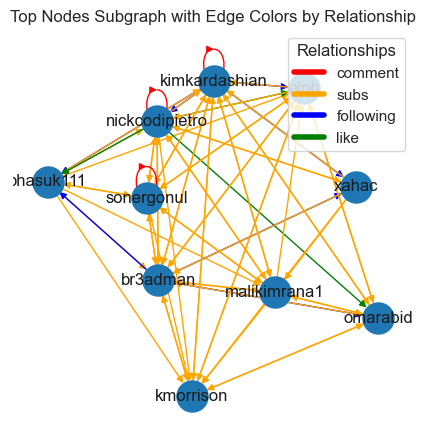

In [16]:
# Step 1: Specify the number of nodes to sample based on the most connections (highest degree)
num_nodes_to_sample = 10  # Set your desired number of nodes

# Get the degrees of all nodes (degree is the number of edges connected to a node)
node_degrees = dict(G.degree())

# Sort nodes by degree in descending order and select the top ones
sampled_nodes = sorted(node_degrees, key=node_degrees.get, reverse=True)[:num_nodes_to_sample]

# Step 2: Create a subgraph from the sampled nodes
G_sampled = G.subgraph(sampled_nodes).copy()

# Step 3: Prepare edge colors based on relationships
edge_colors = []
for u, v, data in G_sampled.edges(data=True):
    relationship = data['relationship']
    if relationship == 'following':
        edge_colors.append('blue')
    elif relationship == 'subs':
        edge_colors.append('orange')
    elif relationship == 'like':
        edge_colors.append('green')
    elif relationship == 'comment':
        edge_colors.append('red')
    else:
        edge_colors.append('gray')

# Step 4: Plot the sampled subgraph with colored edges
plt.figure(figsize=(4, 4))  # Set the plot size
nx.draw(G_sampled, node_size=500, edge_color=edge_colors, with_labels=True)

# Step 5: Create a legend for the edges
colors = {'following': 'blue', 'subs': 'orange', 'like': 'green', 'comment': 'red', 'other': 'gray'}

# Create legend entries
unique_relationships = set(data['relationship'] for _, _, data in G_sampled.edges(data=True))
for relationship in unique_relationships:
    plt.plot([], [], color=colors.get(relationship, 'gray'), label=relationship, linewidth=4)

plt.title('Top Nodes Subgraph with Edge Colors by Relationship')
plt.legend(title='Relationships', loc='upper right', bbox_to_anchor=(1, 1))
plt.show()


In [17]:
print(input('I am waiting: ...'))

I am waiting: ... 


In [18]:
# Create a list of tuples (node, degree) and sort by degree in descending order
num_nodes_to_sample = 10
sorted_nodes_with_degrees = sorted(node_degrees.items(), key=lambda item: item[1], reverse=True)[:num_nodes_to_sample]

# Display the sorted nodes with their degrees
for node, degree in sorted_nodes_with_degrees:
    print(f"Node: {node}, Degree: {degree}")

Node: br3adman, Degree: 178290
Node: malikimrana1, Degree: 166401
Node: sonergonul, Degree: 159406
Node: phasuk111, Degree: 159201
Node: omarabid, Degree: 143402
Node: xahac, Degree: 133903
Node: alpb, Degree: 109659
Node: nickcodipietro, Degree: 108931
Node: kimkardashian, Degree: 102530
Node: kmorrison, Degree: 102211


In [19]:
# Free up the memory
del users, subs, following, comments, likes, entries
gc.collect()

7975

### Save the network

In [25]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

# Print graph information
print(f"Graph type: {type(G)}")
print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")

Graph type: <class 'networkx.classes.digraph.DiGraph'>
Number of nodes: 645414
Number of edges: 39562155


with gzip.open('graph/graph.graphml.gz', 'wb') as f:
    nx.write_graphml(G, f)


In [28]:
# Extract only the edge tuples (without the edge attributes)
batch_size = 4000000  # Number of edges per file

# Extract only the edge tuples (ignoring the attributes)
edges = [(u, v) for u, v, _ in G.edges(data=True)]

for i in range(0, len(edges), batch_size):
    chunk = edges[i:i + batch_size]
    # Create a subgraph with these edges
    subgraph = G.edge_subgraph(chunk)
    nx.write_graphml(subgraph, f"graph/graph_batch_{i//batch_size}.graphml")


In [29]:
# Missing attributes
i = 0
for u, v, attrs in G.edges(data=True):
    print(f"Edge from {u} to {v} has attributes: {attrs}")
    i += 1
    if i == 10:
        break

Edge from spaceastronautics to dontia has attributes: {'relationship': 'subs'}
Edge from spaceastronautics to doruman10 has attributes: {'relationship': 'subs'}
Edge from spaceastronautics to dotwonder has attributes: {'relationship': 'subs'}
Edge from spaceastronautics to dougclose has attributes: {'relationship': 'subs'}
Edge from spaceastronautics to douglance has attributes: {'relationship': 'subs'}
Edge from spaceastronautics to douglasi has attributes: {'relationship': 'subs'}
Edge from spaceastronautics to dougplanet has attributes: {'relationship': 'subs'}
Edge from spaceastronautics to dpease has attributes: {'relationship': 'subs'}
Edge from spaceastronautics to dpeter has attributes: {'relationship': 'subs'}
Edge from spaceastronautics to draven666 has attributes: {'relationship': 'subs'}
